# Show that this implementation can work with a very low tolerance

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import cmocean
from xmitgcm import open_mdsdataset,utils
from xgcm import Grid
import ecco_v4_py

import pych.ecco as pe

import pych
from matern import MaternField
from llcutils import get_pacific
from new_smooth_store import open_smoothdataset

In [2]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

/scratch2/tsmith/miniconda3/envs/phd/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
cluster = SLURMCluster()
cluster.adapt(minimum=0, maximum=10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.1.1.6:8787/status,
Dashboard: http://10.1.1.6:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.1.1.6:41102,Workers: 0
Dashboard: http://10.1.1.6:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
plt.style.use('./correlation.mplstyle')

In [6]:
xi = 1

In [140]:
def readme(n_range, log10tol, n_samples=100, drop_coords=True):
    run_dir = f'/scratch2/tsmith/generic-matern-covariance/sampling/llc90/matern-sample-log10tol{log10tol:03d}-3D-C/run.{n_range:02d}dx.{xi:02}xi'
    ds = open_smoothdataset(data_dir=run_dir+'/smooth-output',
                            grid_dir=run_dir,
                            geometry='llc',
                            k_chunksize=50,
                            iter_stop=n_samples)
    
    ds = ds.chunk({'sample':100})
    ds = get_pacific(ds)
    if drop_coords:
        with xr.set_options(keep_attrs=True):
            
            ds['variance'] = 1/ds['smooth3Dnorm001']**2
            ds['sigma'] = 1/ds['smooth3Dnorm001']
            ds['ginv_norm'] = (ds['smooth3Dfld001'] * ds['smooth3Dnorm001'] ).where(ds.maskC)
            
            ds['variance'].attrs = {'label':r'$\hat{\sigma}^2$'}
            ds['sigma'].attrs = {'label':r'$\hat{\sigma}$'}
            ds['smooth3Dmean001'] = ds['smooth3Dfld001'].mean('sample')
        ds = ds.reset_coords(drop=True)
    
        myiters = pych.read_jacobi_iters(f'{run_dir}/STDOUT.0000',
                               which_jacobi='3D')
        myiters = xr.DataArray(myiters[:len(ds.sample)], ds.sample.coords, ds.sample.dims,
                               attrs={'description': 'Number of iterations to converge, given tolerance and range'})
        ds['sor_iters'] = myiters
    return ds

In [9]:
all_tol = [-1, -2, -12]
dsrt = {}
n_samples = 100
for n_range in [5, 10]:
    dsrt[n_range] = {tol: readme(n_range, tol, n_samples=n_samples) for tol in all_tol}

# Get a single grid dataset and drop the others
grid = readme(5, 0, drop_coords=False).coords.to_dataset()

In [11]:
grid['maskC'] = grid['maskC'].persist()
for n_range, dst in dsrt.items():
    for log10tol, xds in dst.items():
        for key in ['smooth3Dnorm001','smooth3Dmean001','ginv_norm']:
            xds[key] = xds[key].persist()

### Correlation lengths

In [12]:
def calc_correlation_field(xda, mask, sample_mean,
                           dimlist=('k',),
                           n_shift=15, 
                           selection=None):
    xds = xr.Dataset()
    
    # Do this part once
    x_deviation = (xda - sample_mean).persist()
    x_ssr_inv = (1/np.sqrt( (x_deviation.sel(selection)**2).sum('sample') )).persist()
    
    shifty = np.arange(-n_shift,n_shift+1)
    xds['shifty'] = xr.DataArray(shifty, coords={'shifty':shifty}, dims=('shifty',))
    for dim in dimlist:
        cname = f'corr_{dim}'
        
        avg_corr = []
        std_corr = []
        q_corr = []
        for s in shifty:
            avg, std = _xcalc_shifted(x_deviation, x_ssr_inv, int(s), dim, selection)
            avg_corr.append(avg)
            std_corr.append(std)
            #q_corr = _xcalc_shifted(x_deviation, x_ssr_inv, int(s), dim, selection)
        xds[cname+'_avg'] = xr.concat(avg_corr, dim='shifty')
        xds[cname+'_std'] = xr.concat(std_corr, dim='shifty')
        #xds[cname] = xr.concat()
        
    return xds.persist()

def _xcalc_shifted(xdev, xssrinv, n_shift, dim, selbox):
    
    y_deviation = xdev.shift({dim:n_shift}).sel(selbox)
    numerator = (xdev.sel(selbox)*y_deviation).sum('sample')
    y_ssr = np.sqrt( (y_deviation**2).sum('sample'))
    full_field = numerator / y_ssr * xssrinv
    
    sum_dims = tuple(x for x in xssrinv.dims if x != dim)
    #quantile = full_field.quantile([.2, .5, .8], dim=sum_dims, method='inverted_cdf').expand_dims({'shift':[n_shift]})
    #return quantile
    avg = full_field.mean(sum_dims).expand_dims({'shifty':[n_shift]})
    std = full_field.std(sum_dims).expand_dims({'shifty':[n_shift]})
    return avg, std

In [13]:
# Compute approximate correlation
outer = {'ix':slice(40,120), 'iy':slice(200,45)}
inner = {'ix':slice(60,100), 'iy':slice(160,80)}

cdsrt = {}
for n_range, dst in dsrt.items():
    cdst = {}
    for log10tol, xds in dst.items():
        cc = calc_correlation_field(xds['ginv_norm'].sel(outer),
                                               mask=grid['maskC'].sel(outer),
                                               sample_mean=xds['smooth3Dmean001'].sel(outer),
                                               dimlist=('ix','iy','k'),
                                               n_shift=2*xi*n_range,
                                               selection=inner)
    
        cc['delta_khat'] = np.abs(cc['shifty'])
        cdst[log10tol] = cc
    cdsrt[n_range] = cdst

## Plotting todo list

- For now, show STD, but take this away after I see it for presentation
- Repeat for all dimensions, save 2 for supplement / appendix
- Work out condition to plot the average over absolute value of shifty

In [135]:
def plot_correlation(xds, log10tol, n_range, ax):
    label = r'$10^{%d}$' % log10tol if n_range==5 else None
    
    # for simplicity, just showing positive, but it's the same either way...
    condition = xds['shifty'] >= 0
    x = xds[f'delta_khat'].where(condition)
    if dim == 'k':
        condition = condition & (x<25)
        
    yavg = xds[f"corr_{dim}_avg"].sel({dim:dsel}).where(condition)
    ystd = xds[f"corr_{dim}_std"].sel({dim:dsel}).where(condition)
    
    ls = '' if log10tol == -2 else '-'
    marker = 'o' if log10tol == -2 else ''
    color = 'k' if log10tol == -12 else None
    ax.plot(x, yavg, ls=ls, marker=marker,
            color=color, zorder=12+log10tol, label=label)
    ax.fill_between(x,yavg-ystd, yavg+ystd,
                    alpha=.3)

In [136]:
def plot_all_correlations(dim, dsel, bigdict):
    
    ncols = 3
    nrows = 1
    fig,axs = plt.subplots(nrows, ncols,
                           figsize=(18,5*nrows))
    
    for (n_range, cdst), ax in zip(bigdict.items(), axs):
        
        for log10tol, xds in cdst.items():
            plot_correlation(xds, log10tol, n_range, ax=ax)
            lbl = dim[-1]
            lbl = 'z' if lbl == 'k' else lbl
        ax.set(xlabel=r'$\delta\hat{%s}$' % lbl,ylabel='',title='')
        ax.text(1, 0, r'$\hat{\rho} = %d$' % n_range)
            
    axs[0].set_ylabel('Correlation')
    axs[1].set(yticklabels=[])
    
    fig.subplots_adjust(wspace=.15)
    fig.legend(ncol=5,
               loc='center',
               bbox_to_anchor=(.33,-0.075),
               frameon=False)

    return fig, axs

In [137]:
def plot_iterations(iterdict, ax):
    width = .4
    for i, (n_range, xdst) in enumerate(iterdict.items()):
        
        bars = [xds['sor_iters'].mean('sample') for xds in xdst.values()]
        x = list(1 + xi + i*width - width for xi in range(len(xdst)))
        
        ax.bar(x, bars, align='edge', width=width)
        
    ax.set(xticks=[xx +1 for xx in range(len(xdst))],
           xticklabels=[r'$10^{%d}$' % t for t in xdst.keys()])
    ax.set(xlabel='Tolerance', ylabel='Iterations')

In [130]:
kk = 25
ix = 80
iy = 120

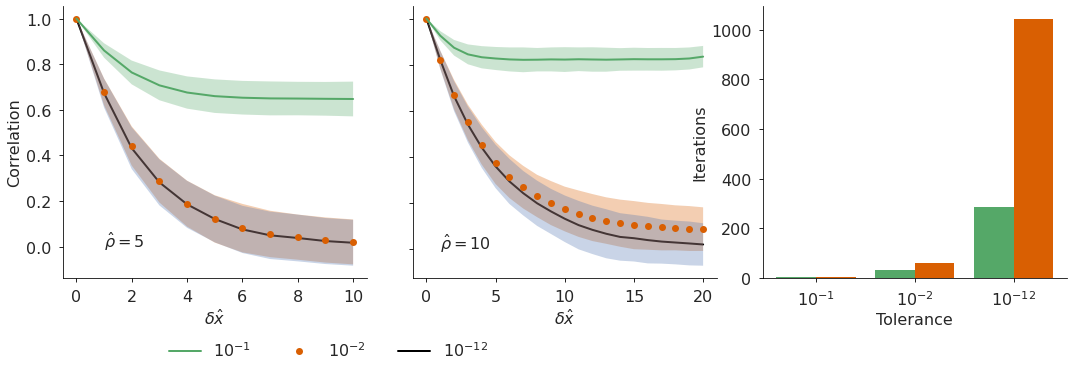

In [142]:
dim = 'ix'
dsel = ix

fig, axs = plot_all_correlations(dim=dim, dsel=dsel, bigdict=cdsrt)
plot_iterations(iterdict=dsrt, ax=axs[-1])
fig.savefig(f'{fig_dir}/matern_llc90_tolerance-{dim}{dsel}-{n_samples}samples.pdf',bbox_inches='tight')

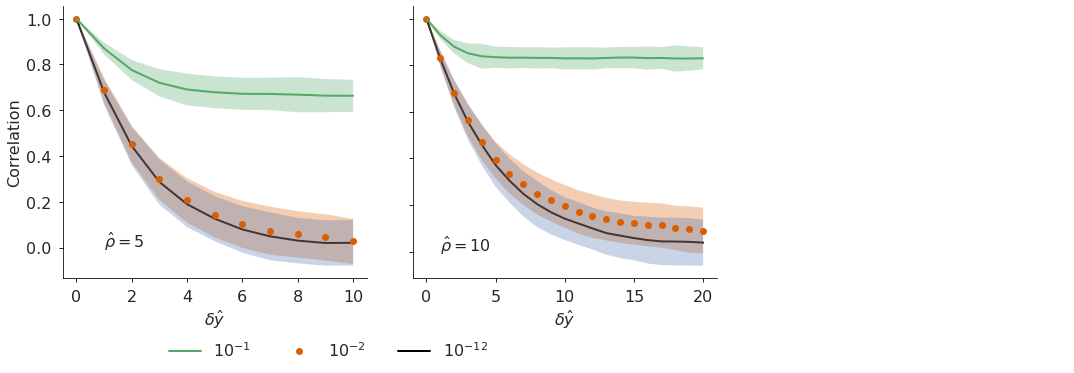

In [143]:
dim = 'iy'
dsel = iy

fig, axs = plot_all_correlations(dim=dim, dsel=dsel, bigdict=cdsrt)
axs[-1].axis('off')
fig.savefig(f'{fig_dir}/matern_llc90_tolerance-{dim}{dsel}-{n_samples}samples.pdf',bbox_inches='tight')

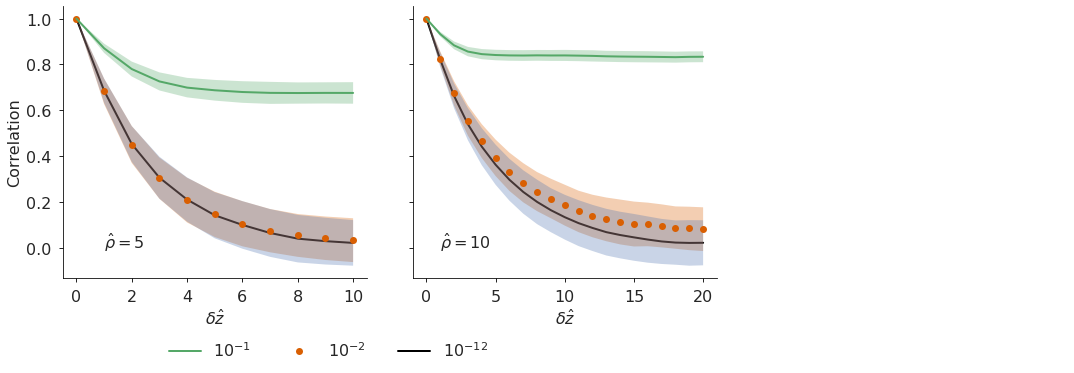

In [144]:
dim = 'k'
dsel = kk

fig, axs = plot_all_correlations(dim=dim, dsel=dsel, bigdict=cdsrt)
axs[-1].axis('off')
fig.savefig(f'{fig_dir}/matern_llc90_tolerance-{dim}{dsel}-{n_samples}samples.pdf',bbox_inches='tight')